In [1]:
# Import required libraries
import pandas as pd
from sqlalchemy import create_engine

# Connection string
db_connection_string = "your-connection-string"

# Create the engine
try:
    engine = create_engine(db_connection_string)
    print("Database connection successful.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# SQL query to fetch competitor-level data
query = """
SELECT 
    c.competitor_id, 
    c.property_id, 
    c.business_type_id, 
    c.weighted_rating, 
    c.aggregate_sentiment, 
    c.business_age, 
    c.rating, 
    c.user_ratings_total, 
    c.distance_to_station_km, 
    c.foot_traffic_proxy, 
    c.total_spending_adjusted, 
    c.food_and_beverages_adjusted, 
    c.healthcare_adjusted, 
    c.housing_adjusted, 
    c.gas_and_energy_adjusted, 
    c.other_spending_adjusted, 
    c.total_population, 
    c.median_household_income, 
    c.total_aadt,
    c,census_tract,
    bt.category_id,
    cat.category_name
FROM competitors c
JOIN business_types bt ON c.business_type_id = bt.business_type_id
JOIN categories cat ON bt.category_id = cat.category_id
"""

# Execute the query and load into a DataFrame
competitors_df = pd.read_sql(query, engine)
print("Data with categories loaded successfully.")
print(competitors_df.head())




Database connection successful.
Data with categories loaded successfully.
   competitor_id  property_id  business_type_id  weighted_rating  \
0            191          334                43         4.189744   
1            401          365                44         4.695032   
2            599          228                95         4.000000   
3            673          311                56         2.500000   
4            675          464                56         4.366917   

   aggregate_sentiment  business_age  rating  user_ratings_total  \
0              0.64010           9.0     4.3                  38   
1              0.70030           0.0     4.7                 945   
2              0.07760           8.0     4.5                   8   
3              0.00000           5.0     5.0                   1   
4              0.91055           0.0     4.4                 132   

   distance_to_station_km  foot_traffic_proxy  ...  housing_adjusted  \
0                     NaN           

In [2]:
# Add competitor count
competitors_df['competitor_count'] = competitors_df.groupby('property_id')['competitor_id'].transform('count')

# Confirm addition
print("Competitor Count Feature Added:")
print(competitors_df[['property_id', 'competitor_count']].head())


Competitor Count Feature Added:
   property_id  competitor_count
0          334                14
1          365                20
2          228                12
3          311                25
4          464                38


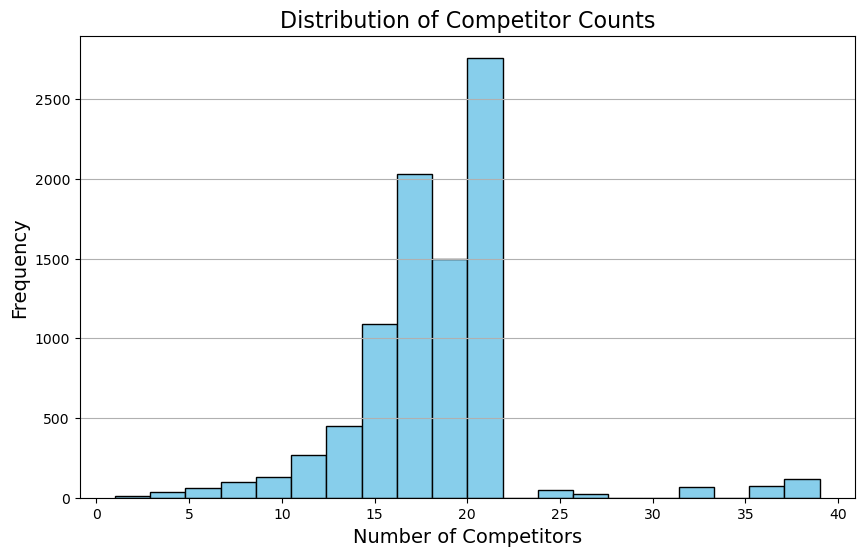

In [3]:
# Competitor Count Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
competitors_df['competitor_count'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Competitor Counts', fontsize=16)
plt.xlabel('Number of Competitors', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y')
plt.show()


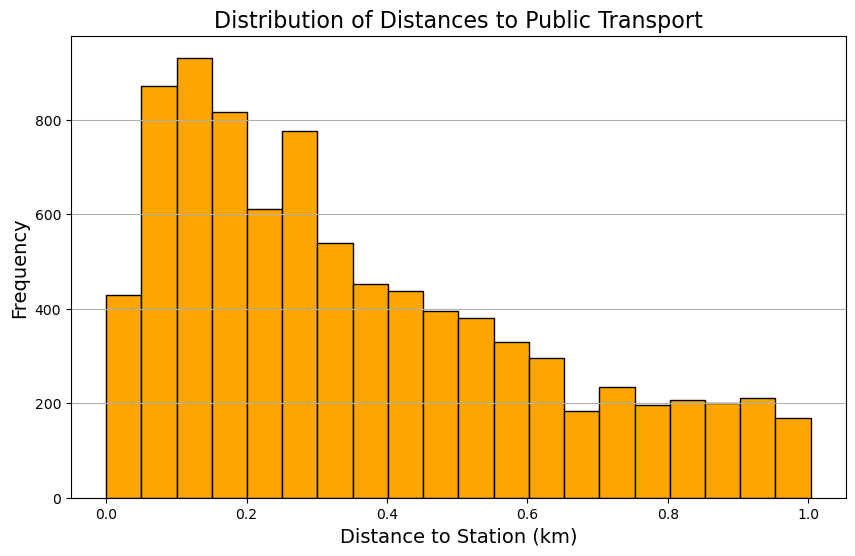

In [4]:
# Distance to Public Transport Distribution
plt.figure(figsize=(10, 6))
competitors_df['distance_to_station_km'].plot(kind='hist', bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Distances to Public Transport', fontsize=16)
plt.xlabel('Distance to Station (km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y')
plt.show()


In [5]:
ea_csv_path = "census_tract_area.csv"  # Replace with the actual path
area_df = pd.read_csv(area_csv_path)

# Ensure columns match for merging
area_df.rename(columns={"GEOID": "census_tract", "Area (sq miles)": "area_sq_miles"}, inplace=True)

# Convert census_tract columns to string in both DataFrames for consistent merging
competitors_df["census_tract"] = competitors_df["census_tract"].astype(str)
area_df["census_tract"] = area_df["census_tract"].astype(str)

# Merge competitors data with area data on census_tract
merged_df = competitors_df.merge(area_df, on="census_tract", how="left")

# Calculate population density (people per square mile)
merged_df["population_density"] = merged_df["total_population"] / (merged_df["area_sq_miles"] * 1e15)

# Replace missing population_density values with the median
population_density_median = merged_df["population_density"].median()
merged_df["population_density"].fillna(population_density_median, inplace=True)

# Print the resulting population_density column
print(merged_df["population_density"])

Rows with null area_sq_miles after merging:
      competitor_id  property_id  business_type_id  weighted_rating  \
0               191          334                43         4.189744   
1               401          365                44         4.695032   
2               599          228                95         4.000000   
3               673          311                56         2.500000   
4               675          464                56         4.366917   
...             ...          ...               ...              ...   
8749           8750          333                28         3.991051   
8750           8751          323                28         3.166667   
8751           8752          366                28         3.166667   
8752           8753          405                28         3.166667   
8753           8754          265                28         4.088889   

      aggregate_sentiment  business_age  rating  user_ratings_total  \
0                 0.64010       

In [6]:
print("Competitors Census Tracts:")
print(competitors_df["census_tract"].dropna().unique()[:10])

print("Area Census Tracts:")
print(area_df["census_tract"].dropna().unique()[:10])


Competitors Census Tracts:
['06055201005' '06001422800' 'None' '06013353002' '06001403900'
 '06041108100' '06001436602' '06041102203' '06085502603' '06085504322']
Area Census Tracts:
['6001442700' '6001442800' '6037204920' '6037205110' '6037205120'
 '6037206010' '6037206020' '6037206050' '6037111402' '6037111303']


In [7]:
area_csv_path = "census_tract_area.csv"  # Replace with the actual path
area_df = pd.read_csv(area_csv_path)

# Ensure columns match for merging
area_df.rename(columns={"GEOID": "census_tract", "Area (sq miles)": "area_sq_miles"}, inplace=True)

# Remove leading zeroes from census_tract in competitors_df
competitors_df["census_tract"] = competitors_df["census_tract"].astype(str).str.lstrip("0")

# Convert both to consistent data types
competitors_df["census_tract"] = competitors_df["census_tract"].astype(str)
area_df["census_tract"] = area_df["census_tract"].astype(str)

# Merge competitors data with area data on census_tract
merged_df = competitors_df.merge(area_df, on="census_tract", how="left")

# Calculate population density (people per square mile) with scaling factor
merged_df["population_density"] = merged_df["total_population"] / (merged_df["area_sq_miles"] * 1e15)

# Compute median population density for valid rows
population_density_median = merged_df["population_density"].median(skipna=True)

# Replace missing population_density values with the median
merged_df["population_density"].fillna(population_density_median, inplace=True)

# Handle rows with null census_tract
merged_df.loc[competitors_df["census_tract"] == "None", "population_density"] = population_density_median
merged_df.loc[competitors_df["census_tract"].isnull(), "population_density"] = population_density_median

# Rename merged_df to competitors_df
competitors_df = merged_df

# Print confirmation
print("Competitors DataFrame updated and ready for machine learning:")
print(competitors_df.head())

Competitors DataFrame updated and ready for machine learning:
   competitor_id  property_id  business_type_id  weighted_rating  \
0            191          334                43         4.189744   
1            401          365                44         4.695032   
2            599          228                95         4.000000   
3            673          311                56         2.500000   
4            675          464                56         4.366917   

   aggregate_sentiment  business_age  rating  user_ratings_total  \
0              0.64010           9.0     4.3                  38   
1              0.70030           0.0     4.7                 945   
2              0.07760           8.0     4.5                   8   
3              0.00000           5.0     5.0                   1   
4              0.91055           0.0     4.4                 132   

   distance_to_station_km  foot_traffic_proxy  ...  total_population  \
0                     NaN                 NaN  .

/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_25113/2878021432.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["population_density"].fillna(population_density_median, inplace=True)


In [8]:
# Count of null values in each column
null_values = competitors_df.isnull().sum()

# Display the null values count
print("Count of null values in each column:")
print(null_values)


Count of null values in each column:
competitor_id                    0
property_id                      0
business_type_id                 0
weighted_rating                  0
aggregate_sentiment              0
business_age                    19
rating                           0
user_ratings_total               0
distance_to_station_km          86
foot_traffic_proxy              86
total_spending_adjusted          0
food_and_beverages_adjusted      0
healthcare_adjusted              0
housing_adjusted                 0
gas_and_energy_adjusted          0
other_spending_adjusted          0
total_population                 0
median_household_income          0
total_aadt                       0
c                                0
census_tract                     0
category_id                      0
category_name                    0
competitor_count                 0
area_sq_miles                  220
population_density               0
dtype: int64


In [9]:
import numpy as np

# Generate random values greater than 1 km for missing entries
random_distances = np.random.uniform(1.0, 5.0, size=competitors_df['distance_to_station_km'].isnull().sum())

# Replace missing values in 'distance_to_station_km' with random values
competitors_df.loc[competitors_df['distance_to_station_km'].isnull(), 'distance_to_station_km'] = random_distances

# Confirm the changes
print("Missing values after replacing 'distance_to_station_km':\n", competitors_df['distance_to_station_km'].isnull().sum())




Missing values after replacing 'distance_to_station_km':
 0


In [10]:
# Fill missing values based on reasoning
competitors_df['foot_traffic_proxy'].fillna(0, inplace=True)  # No public transport -> Proxy = 0

competitors_df['business_age'].fillna(0, inplace=True)  # Business age < 1 year -> Age = 0


# Confirm no missing values remain
print("Missing values after imputation:\n", competitors_df.isnull().sum())

Missing values after imputation:
 competitor_id                    0
property_id                      0
business_type_id                 0
weighted_rating                  0
aggregate_sentiment              0
business_age                     0
rating                           0
user_ratings_total               0
distance_to_station_km           0
foot_traffic_proxy               0
total_spending_adjusted          0
food_and_beverages_adjusted      0
healthcare_adjusted              0
housing_adjusted                 0
gas_and_energy_adjusted          0
other_spending_adjusted          0
total_population                 0
median_household_income          0
total_aadt                       0
c                                0
census_tract                     0
category_id                      0
category_name                    0
competitor_count                 0
area_sq_miles                  220
population_density               0
dtype: int64


/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_25113/3631476592.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  competitors_df['foot_traffic_proxy'].fillna(0, inplace=True)  # No public transport -> Proxy = 0
/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_25113/3631476592.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interme

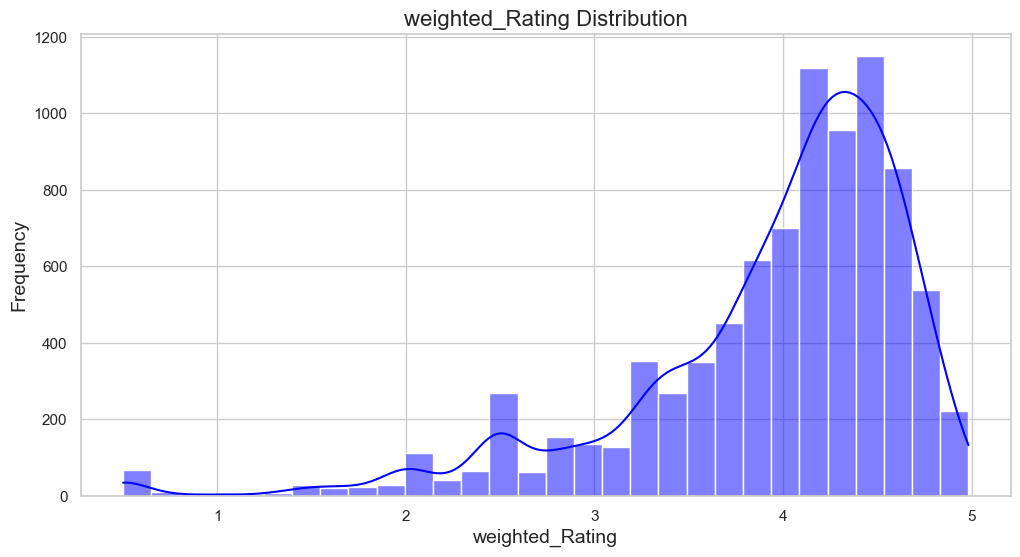

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
sns.set(style="whitegrid")

# Plot Rating Distribution
plt.figure(figsize=(12, 6))
sns.histplot(competitors_df['weighted_rating'], kde=True, bins=30, color="blue")
plt.title("weighted_Rating Distribution", fontsize=16)
plt.xlabel("weighted_Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()






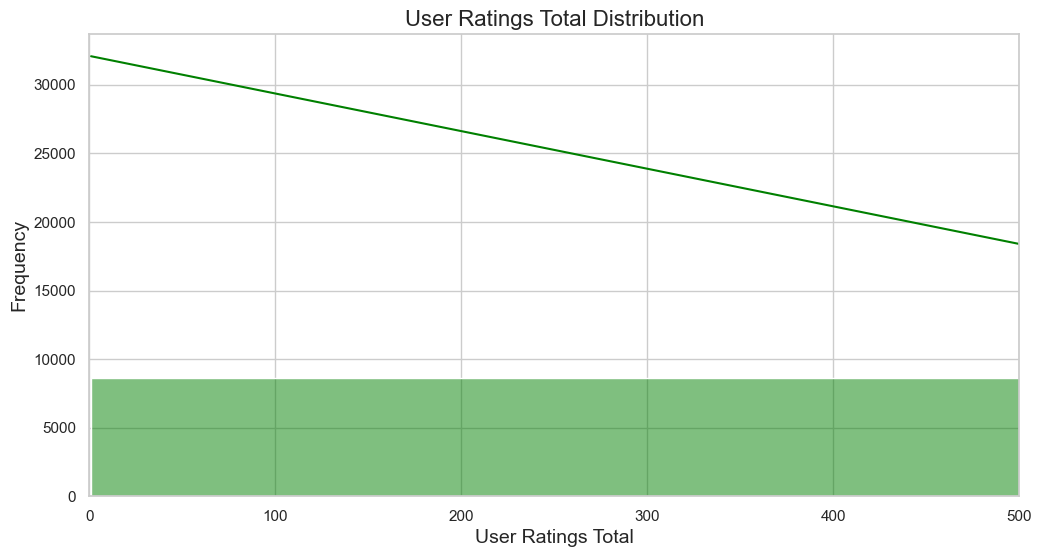

In [14]:


# Plot User Ratings Total Distribution
plt.figure(figsize=(12, 6))
sns.histplot(competitors_df['user_ratings_total'], kde=True, bins=30, color="green")
plt.title("User Ratings Total Distribution", fontsize=16)
plt.xlabel("User Ratings Total", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim(0, 500)  # Limit to focus on most data
plt.show()




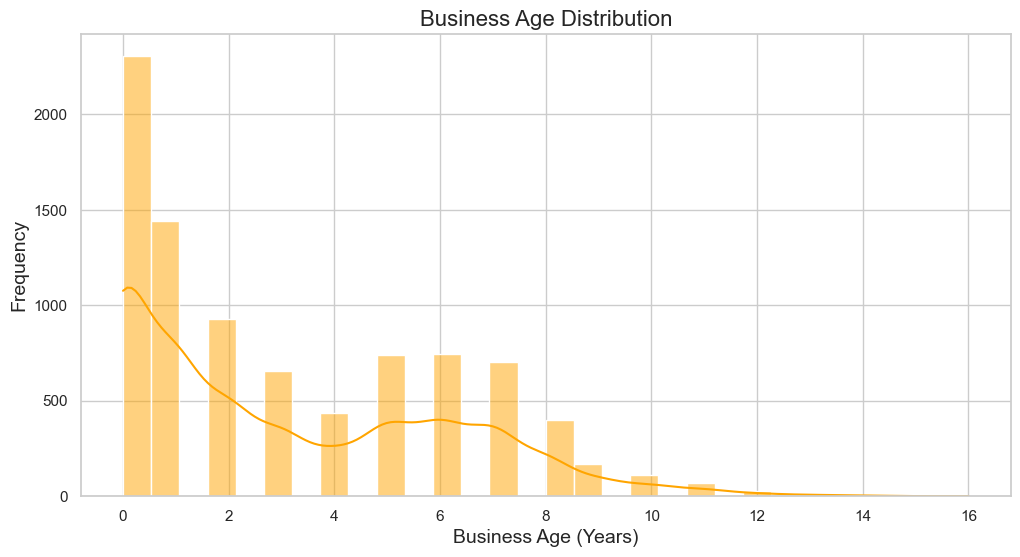

In [23]:
# Plot Business Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(competitors_df['business_age'], kde=True, bins=30, color="orange")
plt.title("Business Age Distribution", fontsize=16)
plt.xlabel("Business Age (Years)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()



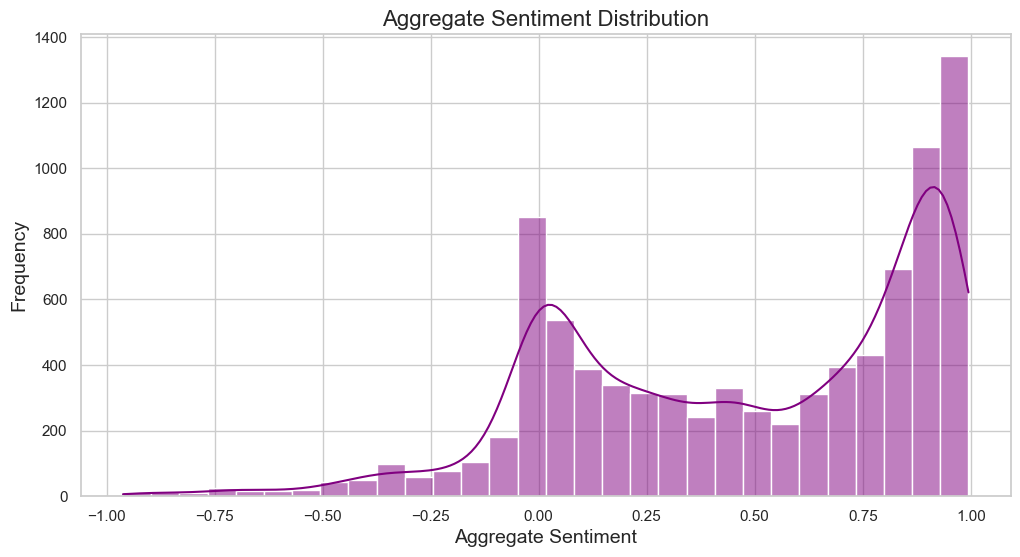

In [24]:
# Plot Aggregate Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(competitors_df['aggregate_sentiment'], kde=True, bins=30, color="purple")
plt.title("Aggregate Sentiment Distribution", fontsize=16)
plt.xlabel("Aggregate Sentiment", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()



In [25]:
def assign_success_category(row):
    # Successful
    if (row['rating'] >= 4.4 and row['user_ratings_total'] >= 50 and row['aggregate_sentiment'] >= 0.7 
        and row['business_age'] >= 0.5) or \
       (row['rating'] >= 4.5 and row['aggregate_sentiment'] >= 0.6 and row['business_age'] < 0.2) or \
       (row['rating'] >= 4.2 and row['user_ratings_total'] >= 200 and row['aggregate_sentiment'] >= 0.65):
        return 'Successful'
    
    # Potential (Expanded criteria)
    elif (3.5 <= row['rating'] < 4.4 and row['aggregate_sentiment'] >= 0.35 and row['user_ratings_total'] > 10)
    or \
         (row['business_age'] < 0.3 and 3.5 <= row['rating'] < 4.5 and row['aggregate_sentiment'] >= 0.3) or \
         (row['business_age'] >= 0.5 and row['rating'] >= 3.8 and row['user_ratings_total'] >= 20) or \
         (row['aggregate_sentiment'] >= 0.45 and row['user_ratings_total'] >= 30):
        return 'Potential'
    
    # Not Successful
    else:
        return 'Not Successful'

# Apply the refined logic
competitors_df['success_category'] = competitors_df.apply(assign_success_category, axis=1)

# Check the updated distribution
print("Updated Success Categories Distribution:\n", competitors_df['success_category'].value_counts())

Updated Success Categories Distribution:
 success_category
Potential         3328
Not Successful    3190
Successful        2236
Name: count, dtype: int64


In [27]:
# Overall statistics
overall_stats = competitors_df[['rating', 'aggregate_sentiment', 'user_ratings_total', 'business_age']].describe()
print("Overall Feature Statistics:\n", overall_stats)

# Statistics by success category
category_stats = competitors_df.groupby('success_category')[['rating', 'aggregate_sentiment', 'user_ratings_total', 'business_age']].agg(['mean', 'std', 'median'])
print("Feature Statistics by Success Category:\n", category_stats)

# Correlation analysis
correlations = competitors_df[['rating', 'aggregate_sentiment', 'user_ratings_total', 'business_age']].corr()
print("Feature Correlations:\n", correlations)

Overall Feature Statistics:
             rating  aggregate_sentiment  user_ratings_total  business_age
count  8754.000000          8754.000000         8754.000000   8754.000000
mean      4.171979             0.480387          531.800777      3.127028
std       0.681297             0.419216         1849.480924      3.021284
min       1.000000            -0.961900            1.000000      0.000000
25%       3.900000             0.090450           20.000000      0.000000
50%       4.300000             0.565475          110.000000      2.000000
75%       4.600000             0.882200          552.000000      6.000000
max       5.000000             0.994600       124961.000000     16.000000
Feature Statistics by Success Category:
                     rating                  aggregate_sentiment            \
                      mean       std median                mean       std   
success_category                                                            
Not Successful    3.924232  0.947

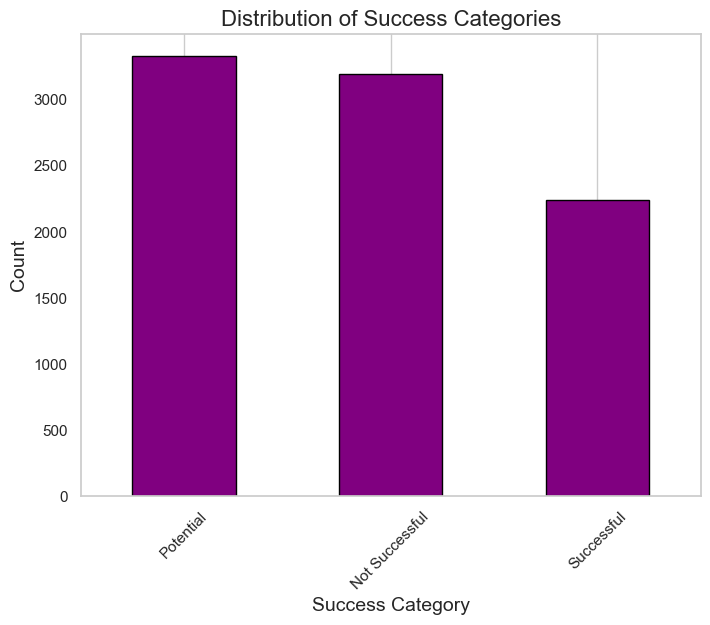

In [29]:
# Success Category Breakdown
success_counts = competitors_df['success_category'].value_counts()

plt.figure(figsize=(8, 6))
success_counts.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Distribution of Success Categories', fontsize=16)
plt.xlabel('Success Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [33]:
from sklearn.preprocessing import LabelEncoder

# Encode success_category into numerical labels
label_encoder = LabelEncoder()
competitors_df['success_category_encoded'] = label_encoder.fit_transform(competitors_df['success_category'])

# Mapping of categories to encoded labels
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:", category_mapping)


Category Mapping: {'Not Successful': 0, 'Potential': 1, 'Successful': 2}


In [35]:
# Define the mapping between categories and spending-adjusted columns
category_to_spending = {
    'Restaurant': ['food_and_beverages_adjusted'],
    'Retail': ['other_spending_adjusted', 'total_spending_adjusted'],
    'Services': ['healthcare_adjusted', 'other_spending_adjusted'],
    'Office': ['housing_adjusted'],
    'Mixed Use': ['other_spending_adjusted']
}

# Calculate spending_adjusted dynamically based on category
def calculate_spending(row):
    category = row['category_name']
    spending_columns = category_to_spending.get(category, [])
    return row[spending_columns].sum() if spending_columns else row['total_spending_adjusted']

# Apply the function to calculate spending_adjusted
competitors_df['spending_adjusted'] = competitors_df.apply(calculate_spending, axis=1)

# Validate the mapping
print(competitors_df[['category_name', 'spending_adjusted']].head(10))


  category_name  spending_adjusted
0      services       1.678187e+08
1        retail       1.299797e+08
2    restaurant       2.668452e+08
3      services       2.668452e+08
4      services       2.668452e+08
5      services       2.668452e+08
6      services       2.668452e+08
7        retail       2.731956e+08
8        retail       2.668452e+08
9        retail       2.668452e+08


In [38]:
from sklearn.preprocessing import LabelEncoder

# Encode business_type_id as a categorical variable
le = LabelEncoder()
competitors_df['business_type_encoded'] = le.fit_transform(competitors_df['business_type_id'])

In [41]:
features = [
    'weighted_rating',         # Composite feature for reviews
    'aggregate_sentiment',
    'population_density',# Already scaled
    'business_age', 
    'foot_traffic_proxy',      # Already scaled
    'spending_adjusted',       # Newly calculated
    'total_population', 
    'median_household_income', 
    'total_aadt',
    'business_type_encoded'    # Encoded business type for granular category information
]

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Features requiring scaling
to_scale = [
    'weighted_rating',        # Add weighted_rating for scaling
    'business_age', 
    'spending_adjusted', 
    'total_population', 
    'median_household_income', 'competitor_count',
    'total_aadt','total_spending_adjusted'
]

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the specified features
competitors_df[to_scale] = scaler.fit_transform(competitors_df[to_scale])

# Confirm scaling
print("Scaled features:")
print(competitors_df[to_scale].head())

# Final feature set
features = [
    'weighted_rating',         # Now scaled
    'aggregate_sentiment',     # Already scaled (range -1 to 1)
    'business_age',            # Now scaled
    'foot_traffic_proxy',      # Already scaled
    'spending_adjusted',       # Now scaled
    'population_density',      # Now scaled
    'median_household_income', # Now scaled
    'total_aadt',              # Now scaled
    'business_type_encoded','competitor_count'    # Encoded business type
]


Scaled features:
   weighted_rating  business_age  spending_adjusted  total_population  \
0         0.823012        0.5625           0.116303          0.194908   
1         0.935718        0.0000           0.089526          0.753356   
2         0.780689        0.5000           0.186380          0.338409   
3         0.446108        0.3125           0.186380          0.338409   
4         0.862531        0.0000           0.186380          0.338409   

   median_household_income  competitor_count  total_aadt  \
0                 0.472061          0.342105    0.181717   
1                 0.044156          0.500000    0.074474   
2                 0.429179          0.289474    0.125861   
3                 0.429179          0.631579    0.730032   
4                 0.429179          0.973684    0.679762   

   total_spending_adjusted  
0                 0.116303  
1                 0.089526  
2                 0.186380  
3                 0.186380  
4                 0.186380  


In [45]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = competitors_df[features]
y = competitors_df['success_category']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm split
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (7003, 10)
Testing set size: (1751, 10)


In [47]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

# Feature importance (optional for insight)
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
                   Feature  Importance
0          weighted_rating    0.328175
1      aggregate_sentiment    0.291611
2             business_age    0.113499
8    business_type_encoded    0.046037
3       foot_traffic_proxy    0.042443
5       population_density    0.039911
7               total_aadt    0.037649
4        spending_adjusted    0.034808
6  median_household_income    0.034312
9         competitor_count    0.031556


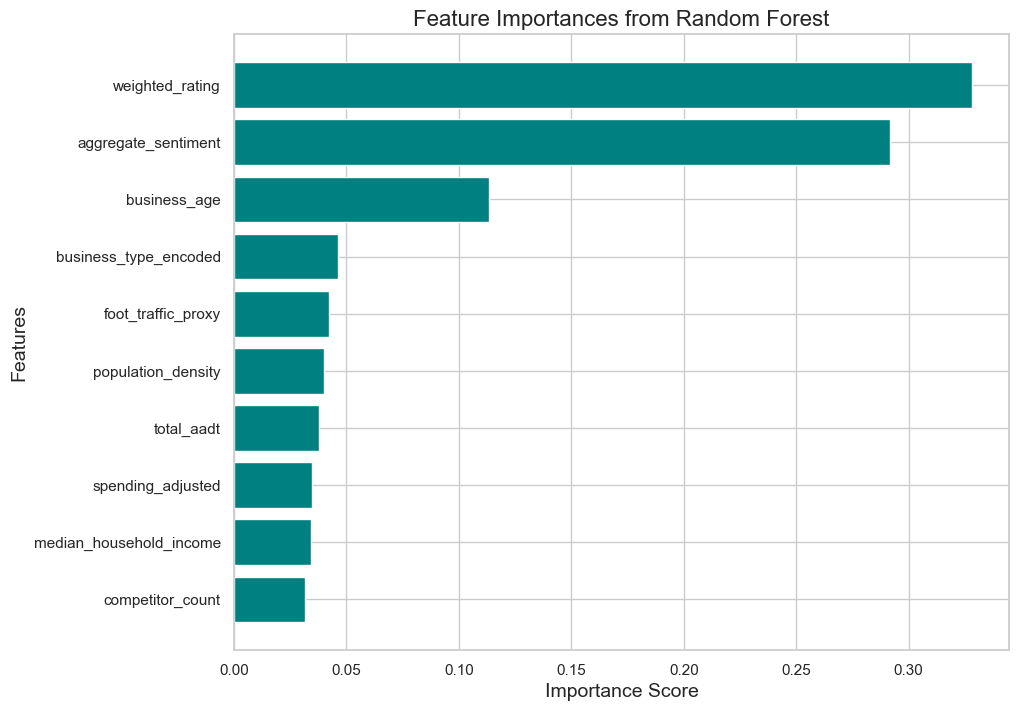

In [48]:
# Feature Importance Visualization
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='teal')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()
plt.show()


In [49]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Classification Report:
                precision    recall  f1-score   support

Not Successful       0.94      0.91      0.93       617
     Potential       0.92      0.92      0.92       679
    Successful       0.91      0.95      0.93       455

      accuracy                           0.93      1751
     macro avg       0.93      0.93      0.93      1751
  weighted avg       0.93      0.93      0.93      1751

Model Accuracy: 0.93


In [54]:
from sklearn.model_selection import train_test_split
# now we will include features that are present in the property level so that we can predict for the properties
# Updated feature set
new_features = [
    'foot_traffic_proxy', 'spending_adjusted', 'median_household_income', 
    'total_aadt', 'business_type_encoded', 'population_density','competitor_count'
]

# Define target variable
target = 'success_category'

# Split data
X = competitors_df[new_features]
y = competitors_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (7003, 7)
Testing set size: (1751, 7)


In [56]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

print("Model trained successfully.")


Model trained successfully.


In [58]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Classification Report:
                precision    recall  f1-score   support

Not Successful       0.66      0.71      0.68       617
     Potential       0.66      0.68      0.67       679
    Successful       0.72      0.60      0.65       455

      accuracy                           0.67      1751
     macro avg       0.68      0.66      0.67      1751
  weighted avg       0.67      0.67      0.67      1751

Accuracy: 0.67


In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
rf_model_optimized = grid_search.best_estimator_


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the optimized model with the best parameters
optimized_rf_model = RandomForestClassifier(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Train the model
optimized_rf_model.fit(X_train, y_train)

print("Optimized Random Forest model trained successfully.")


Optimized Random Forest model trained successfully.


In [62]:
# Make predictions
y_pred_optimized = optimized_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report (Optimized):")
print(classification_report(y_test, y_pred_optimized))

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {accuracy_optimized:.2f}")


Classification Report (Optimized):
                precision    recall  f1-score   support

Not Successful       0.65      0.72      0.68       617
     Potential       0.66      0.68      0.67       679
    Successful       0.74      0.59      0.66       455

      accuracy                           0.67      1751
     macro avg       0.68      0.67      0.67      1751
  weighted avg       0.68      0.67      0.67      1751

Optimized Model Accuracy: 0.67


In [63]:
# Spending Per Capita: Adjust spending relative to population
competitors_df['spending_per_capita'] = competitors_df['spending_adjusted'] / (competitors_df['total_population'] + 1)

# Traffic-Weighted Spending: Combine traffic data with spending
competitors_df['traffic_weighted_spending'] = competitors_df['spending_adjusted'] * competitors_df['foot_traffic_proxy']

# Verify the new features
print("New Features Added:")
print(competitors_df[['spending_per_capita', 'traffic_weighted_spending']].head())


New Features Added:
   spending_per_capita  traffic_weighted_spending
0             0.097332                   0.000000
1             0.051060                   0.045556
2             0.139255                   0.134044
3             0.139255                   0.173501
4             0.139255                   0.115230


In [64]:
features = [
    'foot_traffic_proxy', 
    'spending_adjusted', 
    'median_household_income', 
    'total_aadt', 
    'business_type_encoded', 
    'population_density', 
    'competitor_count', 
    'spending_per_capita', 
    'traffic_weighted_spending'
]

# Define target variable
target = 'success_category'

# Split data
from sklearn.model_selection import train_test_split

X = competitors_df[features]
y = competitors_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (7003, 9)
Testing set size: (1751, 9)


In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=10)
gb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_gb = gb_model.predict(X_test)

print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy (Gradient Boosting): {accuracy_gb:.2f}")


Classification Report (Gradient Boosting):
                precision    recall  f1-score   support

Not Successful       0.72      0.74      0.73       617
     Potential       0.67      0.72      0.69       679
    Successful       0.77      0.66      0.71       455

      accuracy                           0.71      1751
     macro avg       0.72      0.70      0.71      1751
  weighted avg       0.71      0.71      0.71      1751

Accuracy (Gradient Boosting): 0.71


In [67]:

import joblib

# Save the trained Gradient Boosting model
model_filename = 'gradient_competitor_model.pkl'
joblib.dump(gb_model, model_filename)

print(f"Model saved as {model_filename}")


Model saved as gradient_competitor_model.pkl


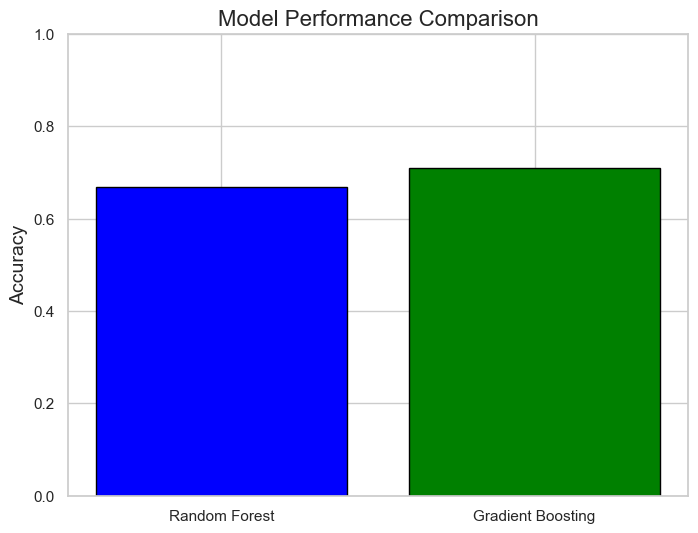

In [68]:
# Model Performance Comparison
model_names = ['Random Forest', 'Gradient Boosting']
accuracies = [accuracy, accuracy_gb]  # Replace with actual accuracy variables for each model

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green'], edgecolor='black')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.show()


In [69]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    'foot_traffic_proxy', 
    'spending_adjusted', 
    'median_household_income', 
    'total_aadt', 
    'business_type_encoded', 
    'population_density', 
    'competitor_count', 
    'spending_per_capita', 
    'traffic_weighted_spending'
]
target = 'success_category'

# Split data
X = competitors_df[features]
y = competitors_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=10)
gb_model.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
y_pred = gb_model.predict(X_test)
print("Classification Report (After SMOTE):")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (After SMOTE): {accuracy:.2f}")

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the mapping
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:", category_mapping)


Class distribution after SMOTE:
success_category
Potential         2649
Successful        2649
Not Successful    2649
Name: count, dtype: int64
Classification Report (After SMOTE):
                precision    recall  f1-score   support

Not Successful       0.70      0.73      0.72       617
     Potential       0.71      0.70      0.70       679
    Successful       0.73      0.69      0.71       455

      accuracy                           0.71      1751
     macro avg       0.71      0.71      0.71      1751
  weighted avg       0.71      0.71      0.71      1751

Accuracy (After SMOTE): 0.71
Category Mapping: {'Not Successful': 0, 'Potential': 1, 'Successful': 2}


In [82]:
# Add competitor_id to ensure mapping is possible after predictions
ids = competitors_df['competitor_id']  # Extract competitor IDs

# Feature and target variables
features = [
    'foot_traffic_proxy', 
    'spending_adjusted', 
    'median_household_income', 
    'total_aadt', 
    'business_type_encoded', 
    'population_density', 
    'competitor_count', 
    'spending_per_capita', 
    'traffic_weighted_spending'
]

target = 'success_category'

# Ensure all features exist in competitors_df
missing_features = [feature for feature in features if feature not in competitors_df.columns]
if missing_features:
    raise ValueError(f"The following features are missing in competitors_df: {missing_features}")

# Split data while keeping competitor_id
X = competitors_df[features]
y = competitors_df[target]
X['competitor_id'] = competitors_df['competitor_id']  # Add competitor_id for mapping

# Split data (ensure to exclude competitor_id during training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate competitor_id for mapping after predictions
X_train_ids = X_train.pop('competitor_id')
X_test_ids = X_test.pop('competitor_id')

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (7003, 9)
Testing set size: (1751, 9)


/var/folders/6k/d7h_35_57qv1xlxwjcj9kzyh0000gn/T/ipykernel_25113/610480789.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['competitor_id'] = competitors_df['competitor_id']  # Add competitor_id for mapping


In [84]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=10)
gb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_gb = gb_model.predict(X_test)

print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy (Gradient Boosting): {accuracy_gb:.2f}")


Classification Report (Gradient Boosting):
                precision    recall  f1-score   support

Not Successful       0.72      0.74      0.73       617
     Potential       0.67      0.72      0.69       679
    Successful       0.77      0.66      0.71       455

      accuracy                           0.71      1751
     macro avg       0.72      0.70      0.71      1751
  weighted avg       0.71      0.71      0.71      1751

Accuracy (Gradient Boosting): 0.71


In [88]:
# Predictions and probabilities
y_pred_probs = gb_model.predict_proba(X_test)

# Create a DataFrame with competitor_id, labels, and probabilities
results = pd.DataFrame({
    'competitor_id': X_test_ids,
    'success_label': y_pred_gb,
    'success_label_prob': y_pred_probs.max(axis=1)  # Probability of the predicted label
})

# Print the results to confirm
print("Predicted Labels and Probabilities:")
print(results.head(50))


Predicted Labels and Probabilities:
      competitor_id   success_label  success_label_prob
3150           3076       Potential            0.970532
5050           4984       Potential            0.971876
8211           8210       Potential            0.839658
7595           7601       Potential            0.882018
994             932       Potential            0.946944
3187           3113  Not Successful            0.980197
5650           5625      Successful            0.962813
6060           6044       Potential            0.727806
5459           5419  Not Successful            0.996192
647             535       Potential            0.476963
1721           1636  Not Successful            0.600025
3601           3566      Successful            0.961182
1373           1312  Not Successful            0.997534
222             149       Potential            0.971608
5140           5081  Not Successful            0.986079
3125           3178  Not Successful            0.551932
3106        

In [90]:
# Ensure the DataFrame has only the required columns
columns_to_load = ['competitor_id', 'success_label', 'success_label_prob']
results_to_load = results[columns_to_load]

# Check the structure before loading
print("Data to be loaded into the database:")
print(results_to_load.head())


Data to be loaded into the database:
      competitor_id success_label  success_label_prob
3150           3076     Potential            0.970532
5050           4984     Potential            0.971876
8211           8210     Potential            0.839658
7595           7601     Potential            0.882018
994             932     Potential            0.946944
